## Importing packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import cv2   #for reading images
import os
import matplotlib.pyplot as plt
import numpy as np

## Viewing a sample image from the dataset using opencv

In [3]:
sample_img=cv2.imread("/content/drive/MyDrive/deep_learning_project/face_expression_dataset/train/angry/Training_2944904.jpg")

In [4]:
sample_img.shape

(48, 48, 3)

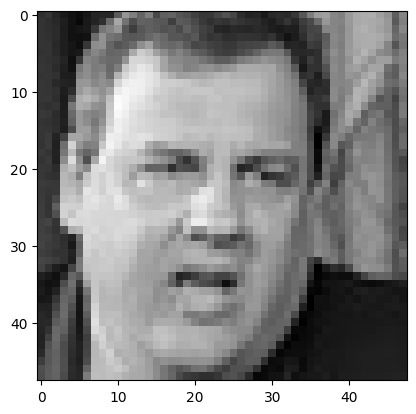

In [5]:
plt.imshow(sample_img)

### The above image is blurry because the pixel width and height are very small(48*48)

## Reading all the training images from all the classes

In [6]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

In [8]:
# Preprocess all train images
train_generator = train_data_gen.flow_from_directory(
        '/content/drive/MyDrive/deep_learning_project/face_expression_dataset/train',
        target_size=(48, 48),
        batch_size=200,
        color_mode="grayscale",
        class_mode='categorical')

Found 8526 images belonging to 7 classes.


In [9]:
# Preprocess all test images
validation_generator = validation_data_gen.flow_from_directory(
        '/content/drive/MyDrive/deep_learning_project/face_expression_dataset/test',
        target_size=(48, 48),
        batch_size=200,
        color_mode="grayscale",
        class_mode='categorical')

Found 1178 images belonging to 7 classes.


# Creating the model

In [10]:
class ResNetBlock(Layer):
  def __init__(self,out_channels, first_stride=1):
    super().__init__()
    first_padding='same'
    if first_stride!=1:
      first_padding='valid'

    self.conv_sequence = Sequential([
        Conv2D(out_channels, 3, first_stride, padding=first_padding),
        BatchNormalization(),
        ReLU(),

        Conv2D(out_channels, 3, 1, padding='same'),
        BatchNormalization(),
        ReLU()
    ])
  def call(self,inputs):
    x= self.conv_sequence(inputs)
    if x.shape == inputs.shape:
      x = x+ inputs   #skip connection

    return x

In [11]:
class ResNet(Model):
  def __init__(self):
    super(ResNet,self).__init__()

    self.input1 = Sequential([
        Conv2D(64, kernel_size=(3,3),strides=(1,1)),
        BatchNormalization(),
        ReLU()
    ])
    self.conv1 = Sequential([
        Conv2D(64, kernel_size=(3,3),strides=(1,1)),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2,2), strides=2,padding='same')
    ])
    self.res1 = Sequential([ResNetBlock(32), ResNetBlock(32)])
    self.drop1 = Dropout(0.5)
    self.conv2 = Sequential([
        Conv2D(64, kernel_size=(3,3),strides=(1,1)),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2,2), strides=2,padding='same')
    ])
    self.res2 = Sequential([ResNetBlock(64), ResNetBlock(64)])
    self.drop2 = Dropout(0.5)
    self.conv3 = Sequential([
        Conv2D(64, kernel_size=(3,3),strides=(1,1)),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2,2), strides=2,padding='same')
    ])
    self.res3 = Sequential([ResNetBlock(128), ResNetBlock(128)])
    self.drop3 = Dropout(0.5)
    self.out = Sequential([
        MaxPool2D(pool_size=(6,6), strides=6,padding='same'),
        Flatten(),
        Dense(7, activation="softmax")
    ])

  def call(self, x):
    x = self.input1(x)
    x = self.conv1(x)
    x = self.res1(x)
    x = self.drop1(x)
    x = self.conv2(x)
    x = self.res2(x)
    x = self.drop2(x)
    x = self.conv3(x)
    x = self.res3(x)
    x = self.drop3(x)
    x = self.out(x)
    return x

In [12]:
model = ResNet()
model.build(input_shape=(None,48,48,1))

In [13]:
model.summary()

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 46, 46, 64)        896       
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        37184     
                                                                 
 sequential_4 (Sequential)   (None, 22, 22, 32)        46720     
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 sequential_5 (Sequential)   (None, 10, 10, 64)        18752     
                                                                 
 sequential_8 (Sequential)   (None, 10, 10, 64)        148736    
                                                                 
 dropout_1 (Dropout)         multiple                  0   

# Compiling our model

In [15]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=1e-4,clipvalue=0.2), metrics=['accuracy'])

# Training our model

In [16]:
%%time
emotion_model_info = model.fit_generator(
        train_generator,
        steps_per_epoch=8526 // 200,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=1178 // 200)

<timed exec>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
42/42 [==============================] - 2004s 47s/step - loss: 2.7631 - accuracy: 0.1746 - val_loss: 1.9321 - val_accuracy: 0.1640
Epoch 2/30
42/42 [==============================] - 15s 357ms/step - loss: 2.0367 - accuracy: 0.1969 - val_loss: 1.9440 - val_accuracy: 0.1380
Epoch 3/30
42/42 [==============================] - 14s 336ms/step - loss: 1.9650 - accuracy: 0.2346 - val_loss: 1.9707 - val_accuracy: 0.1380
Epoch 4/30
42/42 [==============================] - 14s 330ms/step - loss: 1.9071 - accuracy: 0.2507 - val_loss: 1.9927 - val_accuracy: 0.1430
Epoch 5/30
42/42 [==============================] - 17s 400ms/step - loss: 1.8590 - accuracy: 0.2689 - val_loss: 1.9977 - val_accuracy: 0.1430
Epoch 6/30
42/42 [==============================] - 14s 334ms/step - loss: 1.7977 - accuracy: 0.2937 - val_loss: 2.0263 - val_accuracy: 0.1440
Epoch 7/30
42/42 [==============================] - 15s 361ms/step - loss: 1.7732 - accuracy: 0.3037 - val_loss: 2.0222 - val_accuracy: 0.1380

# Saving our model to disk

In [17]:
from tensorflow.keras.models import model_from_json
from keras.models import load_model

# Load the model from disk

In [18]:
# save trained model weight in .h5 file
model.save_weights('/content/drive/MyDrive/deep_learning_project/model/emotion_model.h5')

In [19]:
emotion_model = ResNet()
emotion_model.build(input_shape=(None,48,48,1))
emotion_model.load_weights("/content/drive/MyDrive/deep_learning_project/model/emotion_model.h5")
print("Loaded model from disk")

Loaded model from disk


# Evaluating our model

In [20]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

In [21]:
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

In [22]:
# Initialize image data generator with rescaling
test_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
test_generator = test_data_gen.flow_from_directory(
        '/content/drive/MyDrive/deep_learning_project/face_expression_dataset/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 1178 images belonging to 7 classes.


In [23]:
predictions = emotion_model.predict_generator(test_generator)

<ipython-input-23-5a7f1182a3ff>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = emotion_model.predict_generator(test_generator)


In [24]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy}')

19/19 [==============================] - 2s 93ms/step - loss: 1.5319 - accuracy: 0.4151
Test accuracy: 0.41511034965515137


In [38]:
image_path = '/content/drive/MyDrive/deep_learning_project/face_expression_dataset/train/angry/Training_2944904.jpg'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (48, 48))
img = img / 255.0
img = np.expand_dims(img, axis=-1)
img = np.expand_dims(img, axis=0)
print(img.shape)
predictions = emotion_model.predict_step(img)
predicted_class_index = np.argmax(predictions)
predicted_class = emotion_dict[predicted_class_index]

print(f'Predicted class: {predicted_class}')

(1, 48, 48, 1)
Predicted class: Angry


In [25]:
print(classification_report(test_generator.classes, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.12      0.03      0.05       185
           1       0.14      0.18      0.16       111
           2       0.16      0.08      0.11       225
           3       0.19      0.14      0.16       184
           4       0.14      0.25      0.18       169
           5       0.11      0.27      0.16       158
           6       0.12      0.03      0.04       146

    accuracy                           0.13      1178
   macro avg       0.14      0.14      0.12      1178
weighted avg       0.14      0.13      0.12      1178



# Real time face emotion detection

In [ ]:
import cv2
cap = cv2.VideoCapture(1)
while True:
    # using haar cascade to draw bounding box around face
    try:
      ret, frame = cap.read()
      frame = cv2.resize(frame, (1280, 720))       #resing the image to laptop screen size
      if not ret:
        break
      face_detector = cv2.CascadeClassifier('/content/drive/MyDrive/deep_learning_project/haarcascade_frontalface_default.xml')
      gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      # detect faces available on camera
      num_faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)
       # take each face available on the camera and Preprocess it
      for (x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (0, 255, 0), 4)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)
        # predict the emotions
        emotion_prediction = emotion_model.predict(cropped_img)
        maxindex = int(np.argmax(emotion_prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
      cv2.imshow('Emotion Detection', frame)
      if cv2.waitKey(1) & 0xFF == ord('q'):
         break
    except:
       break


cap.release()
cv2.destroyAllWindows()